# Dependency Loading

In [5]:
from transformers import pipeline
import pandas as pd
import seaborn as sns
from datasets import load_dataset
from datasets import load_dataset
from datasets import Dataset
import datasets as ds
from datasets import DatasetDict
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np

# Data Preparation

In [6]:
# https://huggingface.co/datasets/fhamborg/news_sentiment_newsmtsc
dataset_name = "fhamborg/news_sentiment_newsmtsc"

# Load dataset
dataset_sent = load_dataset(dataset_name)

# Define the columns to keep
columns_to_keep = ["polarity", "sentence"]

# Remove columns from each split
for split in dataset_sent.keys():
    dataset_sent[split] = dataset_sent[split].remove_columns(
        [col for col in dataset_sent[split].column_names if col not in columns_to_keep]
    )
# rename, so that datasets understands what is what
dataset_sent = dataset_sent.rename_columns({"polarity": "label", "sentence": "text"})

# rename because the models only support Z as numbers
df_train = pd.DataFrame(dataset_sent["train"])
df_test = pd.DataFrame(dataset_sent["test"])
df_val = pd.DataFrame(dataset_sent["validation"])

# Concatenate vertically
result_df = pd.concat([df_train, df_test, df_val], axis=0, ignore_index=True)

# Split into train (80%), validation (10%), and test (10%)
train_df, temp_df = train_test_split(result_df, test_size=0.2, random_state=42)
df_val, df_test = train_test_split(temp_df, test_size=0.5, random_state=42)


# recreation the dataset dictionary
dataset_sent = ds.DatasetDict(
    {
        "train": Dataset.from_pandas(df_train),
        "test": Dataset.from_pandas(df_test),
        "validation": Dataset.from_pandas(df_val),
    }
)


# Creation of the test dataframe
test_dataset = pd.DataFrame(dataset_sent["test"])

# Model Loading

In [7]:
sentiment_pipeline_rogerkam = pipeline(model = "RogerKam/roberta_fine_tuned_sentiment_newsmtsc")

In [8]:
sentiment_pipeline_own_model = pipeline(
    model="MaxG1/roberta_fine_tuned_on_newsmstc_02_split"
)

# Let the testing and comparison beginn

In [9]:
for index, row in test_dataset.text.items():
  
    test_dataset.at[index, 'base_feeling_roger'] = int(sentiment_pipeline_rogerkam(row)[0]['label'][6:])

    test_dataset.at[
        index, "base_feeling_own_model"
    ] = sentiment_pipeline_own_model(row)[0]["label"]
    


## Renaming the values, for the classifaction metrcis to work

In [10]:
test_dataset["base_feeling_own_model"].replace(
    {
        "negative": -1,
        "neutral": 0,
        "positive": 1,
    },
    inplace=True,
)

In [11]:
test_dataset['base_feeling_roger'].replace({
    0 : -1,
    1: 0,
    2: 1,  
}, inplace=True)

## Checking the classifcation metrics to see how my model competes

### Metrcis for my own model

In [12]:
true_labels = test_dataset.label
predicted_labels = test_dataset.base_feeling_own_model

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)

# Calculate precision
precision = precision_score(true_labels, predicted_labels, average="weighted")

# Calculate recall
recall = recall_score(true_labels, predicted_labels, average="weighted")

# Calculate F1 score
f1_own = f1_score(true_labels, predicted_labels, average="weighted")

print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1_own:.3f}")

Accuracy: 0.834
Precision: 0.835
Recall: 0.834
F1 Score: 0.832


### Metrcis for the model of roger kam


In [13]:
predicted_labels = test_dataset["base_feeling_roger"]

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)

# Calculate precision
precision = precision_score(true_labels, predicted_labels, average="weighted")

# Calculate recall
recall = recall_score(true_labels, predicted_labels, average="weighted")

# Calculate F1 score
f1_roger = f1_score(true_labels, predicted_labels, average="weighted")

print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1_roger:.3}")

Accuracy: 0.826
Precision: 0.826
Recall: 0.826
F1 Score: 0.824


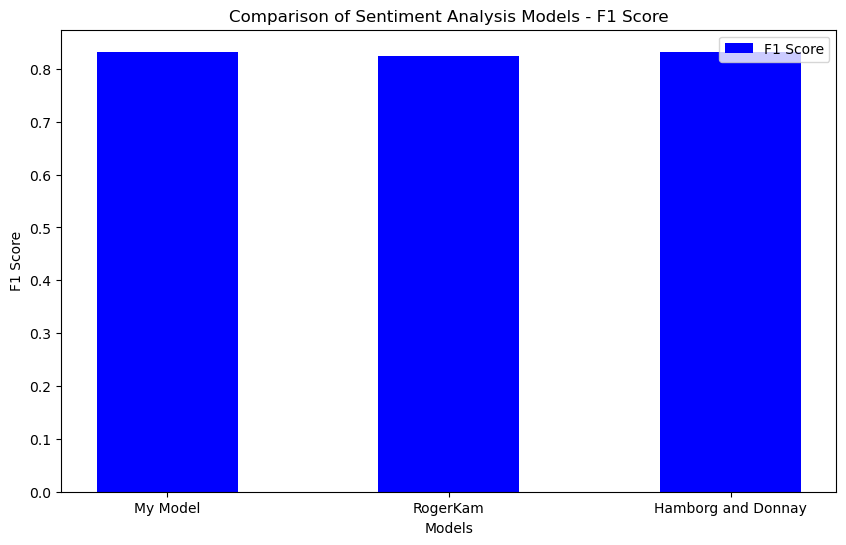

In [14]:
models = ["My Model", "RogerKam", "Hamborg and Donnay"]
F1 = [f1_own, f1_roger, 0.831]

bar_width = 0.5
index = np.arange(len(models))

fig, ax = plt.subplots(figsize=(10, 6))

bars = ax.bar(index, F1, bar_width, label="F1 Score", color="blue")

ax.set_xlabel("Models")
ax.set_ylabel("F1 Score")
ax.set_title("Comparison of Sentiment Analysis Models - F1 Score")
ax.set_xticks(index)
ax.set_xticklabels(models)
ax.legend()

plt.show()